In [1]:

import pandas as pd
pd.set_option("max_colwidth", None)
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import torch
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, NaNLabelEncoder
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, QuantileLoss, MAPE
import locale
import pickle
locale.setlocale(locale.LC_ALL, 'it_IT')
torch.cuda.is_available = lambda : False


In [2]:
df_settimanale = pd.read_csv("processed_data/first_dataset.csv")
df_settimanale["time_idx"] = df_settimanale["time_idx"].astype(int)
df_settimanale["azoto_oraria_max"] = df_settimanale["azoto_oraria_max"].astype(float)
df_settimanale["zolfo_giornaliera"] = df_settimanale["zolfo_giornaliera"].astype(float)
df_settimanale["ozono_8h_max"] = df_settimanale["ozono_8h_max"].astype(float)
df_settimanale["pm2dot5_giornaliera"] = df_settimanale["pm2dot5_giornaliera"].astype(float)
df_settimanale["pm10_giornaliera"] = df_settimanale["pm10_giornaliera"].astype(float)
df_settimanale["provincia"] = df_settimanale["provincia"].astype(str)


In [3]:
df_settimanale=df_settimanale.drop(["Unnamed: 0"], axis=1)
df_settimanale

,provincia,time_idx,azoto_oraria_max,zolfo_giornaliera,ozono_8h_max,pm2dot5_giornaliera,pm10_giornaliera,relative_time_w,relative_time_y,relative_time_m,impianti_rifiuti,siti_inquinati
0,Gorizia,0,28.006272,3.661250,53.649062,16.647083,18.015583,1.0,2014.0,5.125000,39,22
1,Gorizia,1,45.018673,5.331905,13.312857,40.959762,49.991549,2.0,2014.0,1.000000,39,22
2,Gorizia,2,45.632117,4.936048,40.546714,22.282857,29.161928,3.0,2014.0,1.000000,39,22
3,Gorizia,3,44.446463,5.484762,32.052524,14.080952,17.742073,4.0,2014.0,1.000000,39,22
4,Gorizia,4,30.148980,4.187143,57.219524,14.944286,17.136072,5.0,2014.0,1.285714,39,22
...,...,...,...,...,...,...,...,...,...,...,...,...
1790,Udine_S,354,35.199585,0.710000,67.695405,29.528571,35.074369,43.0,2020.0,10.000000,147,78
1791,Udine_S,355,36.749530,0.710000,47.375286,16.853571,22.073046,44.0,2020.0,10.142857,147,78
1792,Udine_S,356,42.611578,0.710000,46.488440,20.578049,27.734112,45.0,2020.0,11.000000,147,78
1793,Udine_S,357,44.871815,0.710000,43.093167,22.157143,25.783116,46.0,2020.0,11.000000,147,78


Provo ad aumentare l'encoder length, che dovrebbe dirmi, semplificando, "quanto guardare indietro" per la previsione.
Si potrebbero inoltre aggiungere features numeriche statiche come media e deviazione standard per almeno il pm10, per ogni provincia.

In [4]:
max_prediction_len = 4
max_encoder_len = 32
training_cutoff = df_settimanale["time_idx"].max() - max_prediction_len

training = TimeSeriesDataSet(
    df_settimanale[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="pm10_giornaliera",
    group_ids=["provincia"],
    min_encoder_length=2,
    max_encoder_length=max_encoder_len,
    max_prediction_length=max_prediction_len,
    static_categoricals=["provincia"],
    static_reals=["impianti_rifiuti", "siti_inquinati"], # da agginugere media e dev_std del pm10
    time_varying_known_categoricals=[],
    time_varying_known_reals=["time_idx","relative_time_w","relative_time_y","relative_time_m"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "azoto_oraria_max","zolfo_giornaliera",
        "ozono_8h_max","pm2dot5_giornaliera","pm10_giornaliera"
    ],
    target_normalizer=GroupNormalizer(
        groups=["provincia"], transformation="relu", scale_by_group=True
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
)

In [5]:
validation = TimeSeriesDataSet.from_dataset(training, df_settimanale, predict=True, stop_randomization=True)

batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=12)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=12)

Calcolo delle performance della baseline, utili per verificare i risultati dell'algoritmo

In [6]:
from sklearn.metrics import mean_absolute_percentage_error

actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_model = Baseline()
baseline_predictions = baseline_model.predict(val_dataloader)
maPe = mean_absolute_percentage_error(actuals, baseline_predictions)
maPe

0.5027668

## Training

Gli iperparametri sono ottimizzati tramite optuna.

In [7]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=20, verbose=False, mode="min")
checkpoint_callback = ModelCheckpoint(
    dirpath='tft_model/',
    filename='{epoch}-{val_loss:.6f}-{val_MAPE:.6f}',
    monitor='val_loss',
    save_top_k=-1,
    every_n_epochs=1
)

pl.seed_everything(42)
trainer = pl.Trainer(
    max_epochs=70,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=3.007658036319129,
    callbacks=[checkpoint_callback]#, early_stop_callback],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.023442288153199226,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    attention_head_size=4,# number of attention heads. Set to up to 4 for large datasets
    dropout=0.21044168084880457,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=10,  # set to <= hidden_size
    output_size=7,  
    loss=QuantileLoss(),
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 29.7k


In [8]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 20    
3  | prescalers                         | ModuleDict                      | 300   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.9 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.3 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.8 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: 0it [00:00, ?it/s]

/home/tfonda/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 5. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
Global seed set to 42
/home/tfonda/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:412: UserWarning: The number of training samples (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/tfonda/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=100,
    max_epochs=20,
    gradient_clip_val_range=(0.01, 100),
    hidden_size_range=(8, 256),
    hidden_continuous_size_range=(8, 256),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.0001, 0.1),
    dropout_range=(0.1, 0.3),
    #trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=True,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study_3.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

In [ ]:
print(study.best_trial.number)

## Valutazione del modello

In [ ]:
#for i, element in enumerate(lr_logger.collection):
#    if i > 0:
#        print("Epoch: {}; val_loss= {}".format(i, element['val_loss']))
checkpoint = torch.load(trainer.checkpoint_callback.best_model_path)
print(checkpoint)

In [9]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
#"/home/tfonda/devel/tft/optuna_test/trial_112/epoch=3.ckpt" #trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [10]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

maPe = mean_absolute_percentage_error(actuals, predictions)
maPe

0.25542497581713836

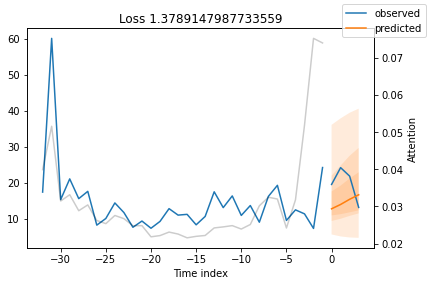

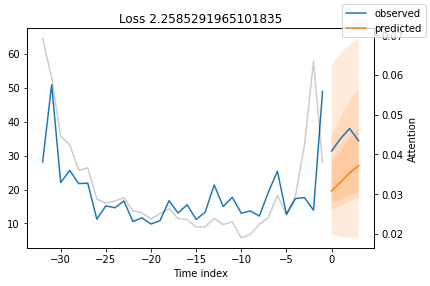

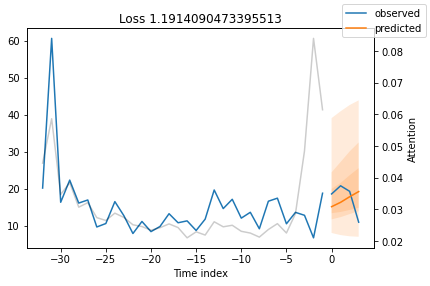

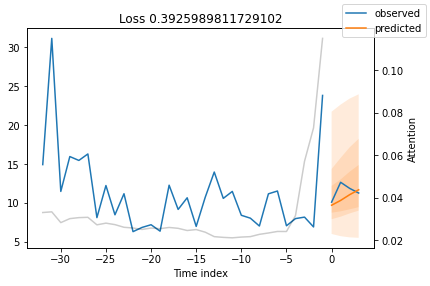

In [11]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)


for idx in range(4):
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

{'impianti_rifiuti': <Figure size 720x360 with 2 Axes>,
 'siti_inquinati': <Figure size 720x360 with 2 Axes>,
 'encoder_length': <Figure size 720x360 with 2 Axes>,
 'pm10_giornaliera_center': <Figure size 720x360 with 2 Axes>,
 'pm10_giornaliera_scale': <Figure size 720x360 with 2 Axes>,
 'time_idx': <Figure size 720x360 with 2 Axes>,
 'relative_time_w': <Figure size 720x360 with 2 Axes>,
 'relative_time_y': <Figure size 720x360 with 2 Axes>,
 'relative_time_m': <Figure size 720x360 with 2 Axes>,
 'relative_time_idx': <Figure size 720x360 with 2 Axes>,
 'azoto_oraria_max': <Figure size 720x360 with 2 Axes>,
 'zolfo_giornaliera': <Figure size 720x360 with 2 Axes>,
 'ozono_8h_max': <Figure size 720x360 with 2 Axes>,
 'pm2dot5_giornaliera': <Figure size 720x360 with 2 Axes>,
 'pm10_giornaliera': <Figure size 720x360 with 2 Axes>,
 'provincia': <Figure size 432x288 with 2 Axes>}

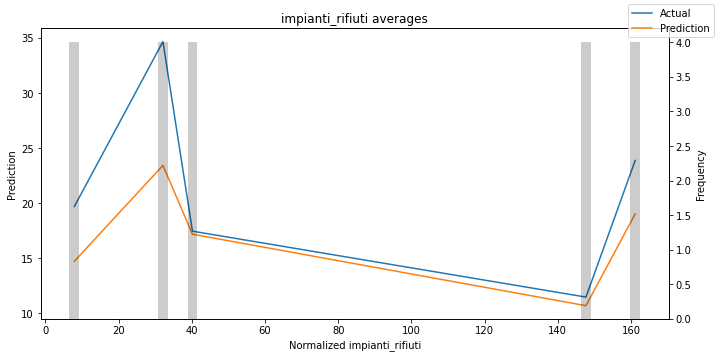

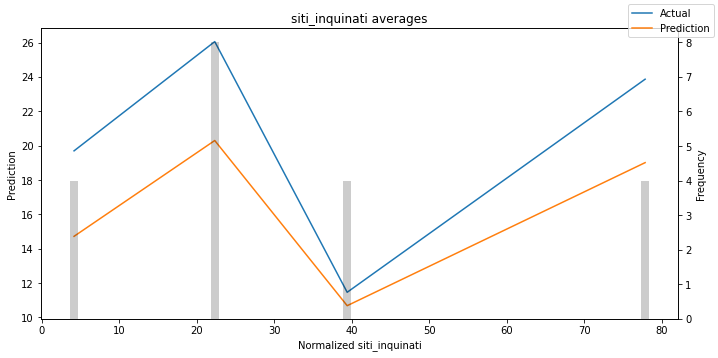

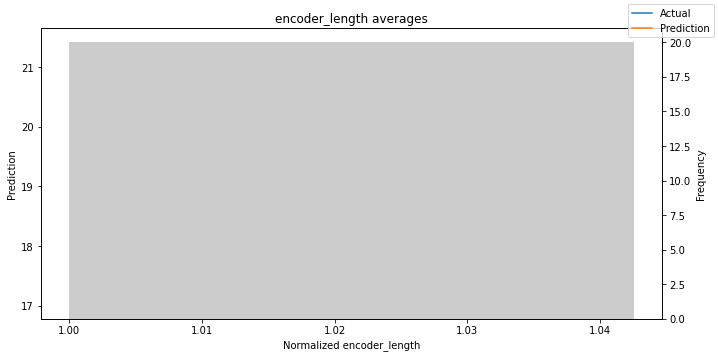

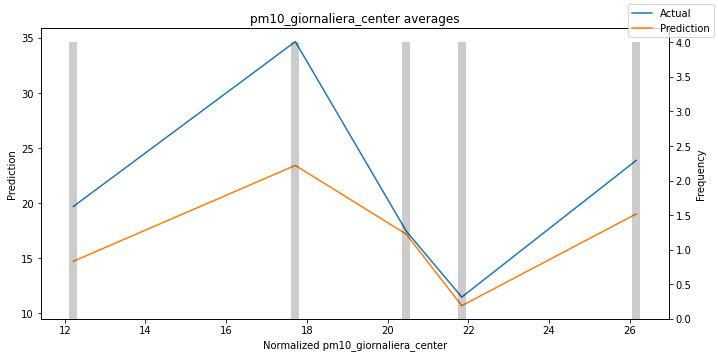

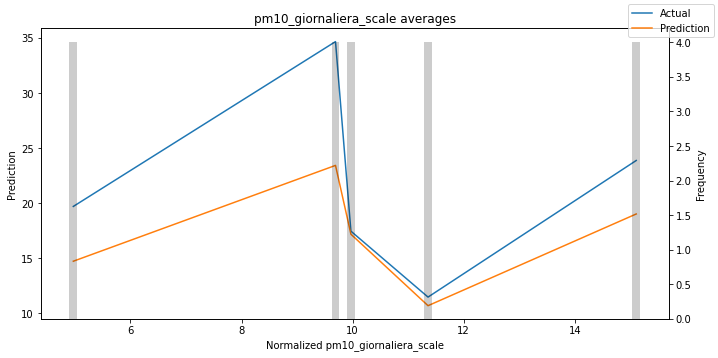

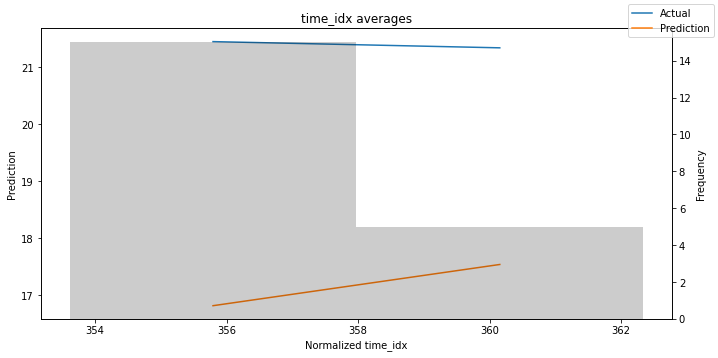

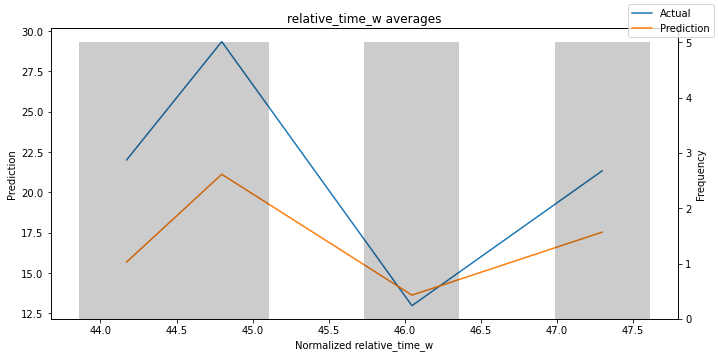

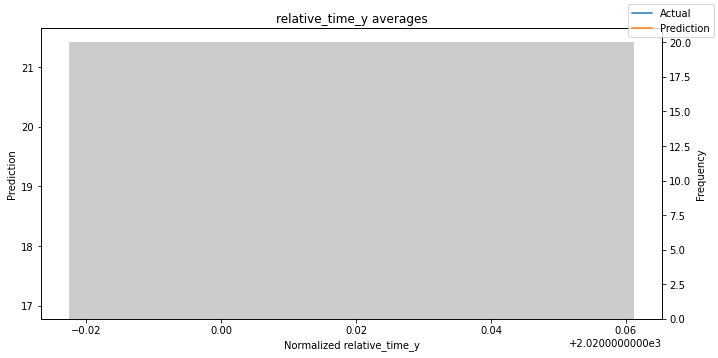

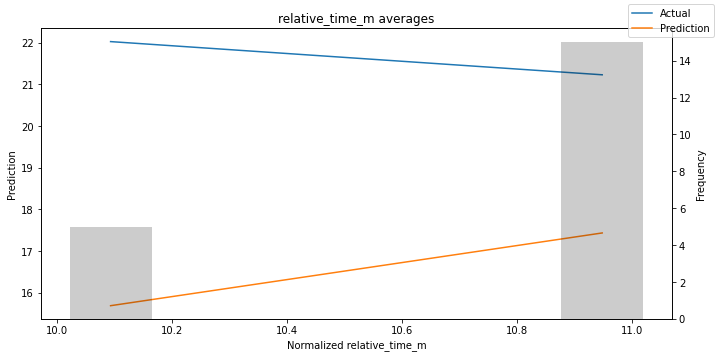

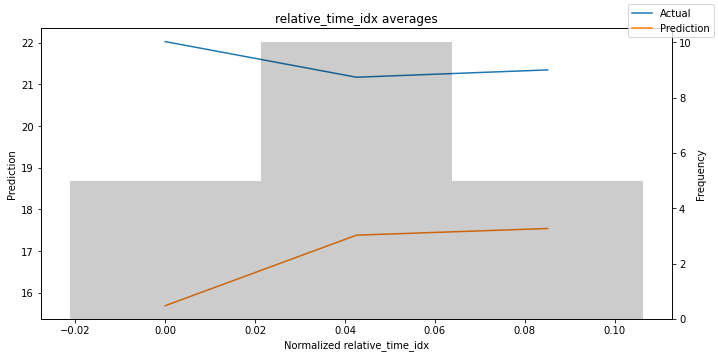

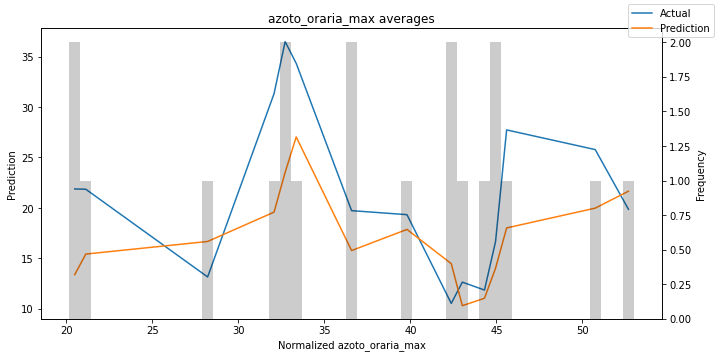

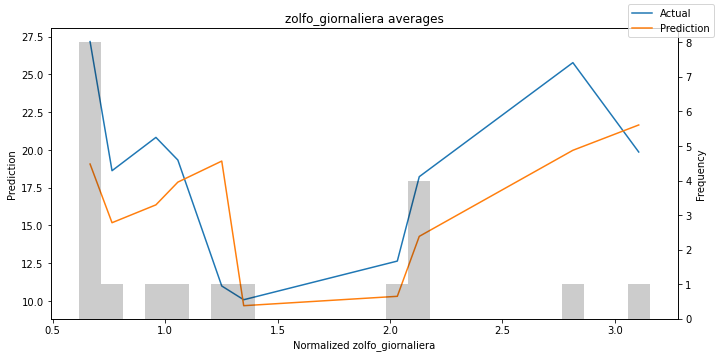

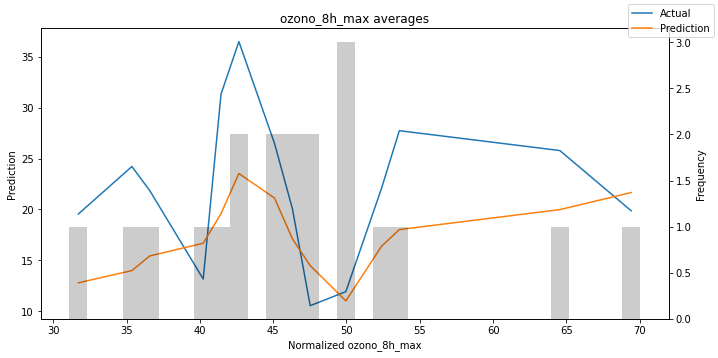

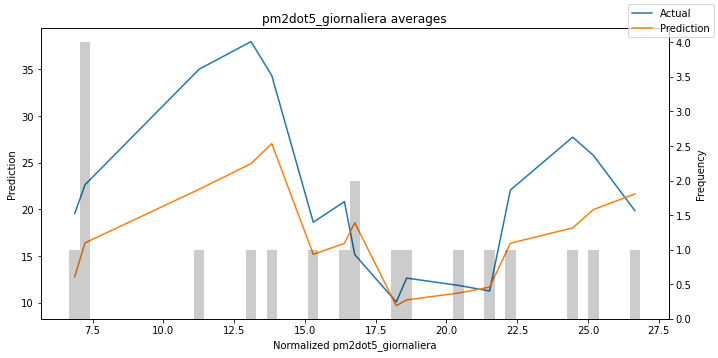

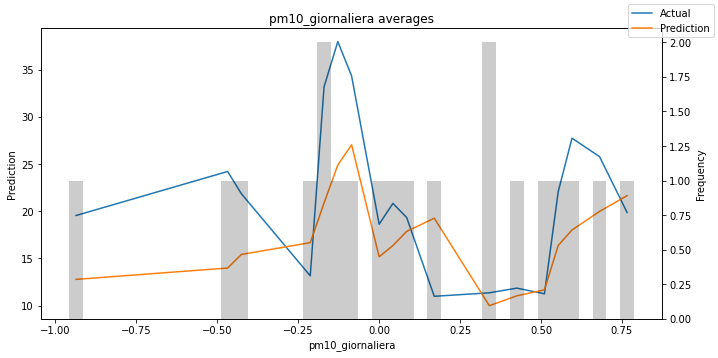

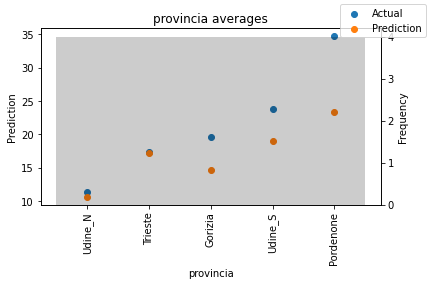

In [12]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

## Grafici

In [ ]:
import plotly.graph_objects as go

In [ ]:
provincia = "Trieste"

raw_prediction, xraw = best_tft.predict(
    training.filter(lambda x: (x.provincia == provincia)),
    mode="prediction",
    return_x=True,
)
baseline_predictions = Baseline().predict(training.filter(lambda x: (x.provincia == provincia)),
    mode="prediction",
    return_x=False)

predicted_df = pd.DataFrame([],columns=["time_idx","values","baseline_values"])
i=0
while i < len(raw_prediction):
    for x in range(0,len(raw_prediction[i])):
        predicted_df = predicted_df.append({"time_idx":xraw["decoder_time_idx"][i][x],"values":raw_prediction[i][x].numpy(),"baseline_values":baseline_predictions[i][x].numpy()},ignore_index=True)
    i += len(raw_prediction[i])
predicted_df["values"] = predicted_df["values"].astype(float)
predicted_df["baseline_values"] = predicted_df["baseline_values"].astype(float)
predicted_df = predicted_df.groupby(by="time_idx").mean().reset_index()
target = df_settimanale[df_settimanale["provincia"]==provincia]
fig = go.Figure()
fig.add_trace(go.Scatter(x=target["time_idx"], y=target["pm10_giornaliera"],mode='lines+markers',name="Realtà"))
fig.add_trace(go.Scatter(x=predicted_df["time_idx"], y=predicted_df["baseline_values"],mode='lines+markers',name="Baseline"))
fig.add_trace(go.Scatter(x=predicted_df["time_idx"], y=predicted_df["values"],mode='lines+markers',name="Predizione"))
fig.show()

In [ ]:
provincia = "Trieste"
raw_prediction, xraw = best_tft.predict(
    validation.filter(lambda x: (x.provincia == provincia)),
    mode="prediction",
    return_x=True,
)
predicted_df = pd.DataFrame([],columns=["time_idx","values"])
i=0
while i < len(raw_prediction):
    for x in range(0,len(raw_prediction[i])):
        predicted_df = predicted_df.append({"time_idx":xraw["decoder_time_idx"][i][x],"values":raw_prediction[i][x].numpy()},ignore_index=True)
    i += len(raw_prediction[i])
predicted_df["values"] = predicted_df["values"].astype(float)
target = df_settimanale[df_settimanale["provincia"]==provincia]
fig = go.Figure()
fig.add_trace(go.Scatter(x=target["time_idx"], y=target["pm10_giornaliera"],mode='lines+markers',name="Realtà"))
fig.add_trace(go.Scatter(x=predicted_df["time_idx"], y=predicted_df["values"],mode='lines+markers',name="Predizione"))
fig.show()